# Sander van de Kamp
#### 500734351 
#### 29/06/2021
# Adverserial Learning

Deze learning techniek bestaat uit twee onderdelen, een generator en een discriminator. De generator is het gedeelte van het model dat afbeeldingen genereert op basis van noise. De discriminator is het gedeelte van het model dat de gegenereerde afbeeldingen van de generator beoordeeld.

Om dit te testen ga ik via de fashion mnist dataset afbeelding classificeren met een CNN model en daarna met de generator ook via een CNN model weer afbeeldingen genereren, een GAN en Auto encoder zijn allebij verschillende manieren om afbeeldingen te genereren. Terwijl de Autoencoder eerst afbeeldingen classificeert en daarna weer probeert op te bouwen, probeert een GAN model via de gegeven afbeeldingen en gemaakte afbeeldingen van de generator te trainen. Hierdoor leert de discriminator het verschil tussen neppe en echte afbeeldingen, daarna om de generator te trainen wordt er 'noise' gegeven aan de generator van de discriminator. Hiermee probeert de generator een afbeelding te maken die de discriminator moet classificeren, als de discriminator denkt dat het echt is dan is het goed gelukt en anders wordt er via een loss functie aanpassingen gemaakt.

GAN probeert afbeeldingen echt er uit te laten zien, terwijl een autoencoder probeert te leren hoe het afbeeldingen na kan maken.

---

| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

In [120]:
from keras.layers import Conv2D, LeakyReLU, Flatten, Dense, Conv2DTranspose, Dropout, Reshape
from keras.datasets.fashion_mnist import load_data
from keras.models import Sequential, load_model
from numpy import ones, zeros, expand_dims
from numpy.random import randn, randint
from keras.optimizers import Adam

import matplotlib.pyplot as plt

Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


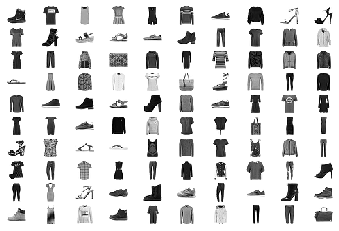

In [121]:
(X_train, y_train), (X_test, y_test) = load_data()
print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)


for i in range(100):
	plt.subplot(10, 10, 1 + i)
	plt.axis('off')
	plt.imshow(X_train[i], cmap='gray_r', interpolation = 'nearest')

## Set up the models

In [3]:
def define_discriminator(in_shape=(28,28,1)):
	model = Sequential()

	# downsamples
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))

	# classifier
	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))
	
	# compile model
	model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
	return model

In [4]:
def define_generator(latent_dim):
	model = Sequential()

	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((7, 7, 128)))

	# upsample to 14x14
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))

	# upsample to 28x28
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))

	# generate
	model.add(Conv2D(1, (7,7), activation='tanh', padding='same'))
	model.compile(loss = 'binary_crossentropy', optimizer = 'adam') # geen performance metric aangezien er afbeeldingen gemaakt worden
	return model

In [5]:
def define_gan(generator, discriminator):
	discriminator.trainable = False

	model = Sequential()
	model.add(generator)
	model.add(discriminator)

	model.compile(loss = 'binary_crossentropy', optimizer = 'adam')
	return model

## Data preparation methods

In [6]:
# load fashion mnist images and transform the imagines into numbers between -1 and 1
def load_real_samples():
	(trainX, _), (_, _) = load_data()

	X = expand_dims(trainX, axis=-1)
	X = X.astype('float32')
	X = (X - 127.5) / 127.5 # [0, 255] list, remove half and divide by halve to get values between -1 and 1
    
	return X

In [7]:
# returns a list of images based on the number of samples required
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	X = dataset[ix]
	y = ones((n_samples, 1))
    
	return X, y

In [8]:
# generates random points in the number areas
def generate_latent_points(latent_dim, n_samples):
	x_input = randn(latent_dim * n_samples)
	x_input = x_input.reshape(n_samples, latent_dim)
    
	return x_input

In [9]:
# use the generator to generate n_samples of new points
def generate_fake_samples(generator, latent_dim, n_samples):
	x_input = generate_latent_points(latent_dim, n_samples)
	X = generator.predict(x_input)
	y = zeros((n_samples, 1))
    
	return X, y

## Create the training method

In [11]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)

	for i in range(n_epochs):
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, _ = d_model.train_on_batch(X_real, y_real)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d1 = %.3f, d2 = %.3f g = %.3f' % (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))

	# save the generator model
	g_model.save('generator.h5')

## Create the models and train them

In [4]:
discriminator = define_discriminator()
generator = load_model('generator.h5')
gan_model = define_gan(generator, discriminator)
data = load_real_samples()
train(generator, discriminator, gan_model, data, latent_dim = 100, n_epochs = 1)

Output weggehaald aangezien het erg lang was


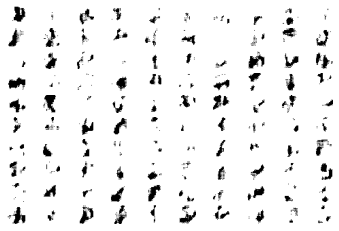

In [17]:
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
 
# create and save a plot of generated images (reversed grayscale)
def show_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		plt.subplot(n, n, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(examples[i, :, :, 0], cmap='gray_r')
	plt.show()
 
model = load_model('generator.h5')
latent_points = generate_latent_points(100, 100)
X = model.predict(latent_points)
show_plot(X, 10)

# Evalutatie
Bron: https://machinelearningmastery.com/how-to-develop-a-conditional-generative-adversarial-network-from-scratch/

Omdat het een standaard GAM model/ Unconditional GAM model is kan er niet gekozen worden wat voor soort kleding stuk er gegenereerd moet worden, aangezien er een willekeurig punt in de "latent space" gekozen wordt als "latent dimension". Deze latent dimension wordt dan gebruikt om de afbeelding te genereren, alleen kan er in de latent space niet gekozen worden wat voor soort kleding stuk het moet zijn. Om dit op te losssen moet er dan ook een conditional GAN gemaakt gaan worden. Dit wordt dan gedaan door een tweede input mee te nemen in de discriminator

GANs kosten veel tijd om volledig te trainen en zijn er ingewikkeld, ik snap het principe er achter wel alleen om het volledig zelf toe te passen is nog erg ingewikkeld. Hierom ga ik hieronder niet het model verbeteren met een conditional GAN, maar in plaats daarvan een GAN maken voor een eigen dataset.

Het voorbeeld dat ik volgde had ook rond de 100 epochs gebruikt om te trainen, alleen duurt het erg lang bij mij om te trainen dus zijn het er maar 5 totaal. Hierdoor is het resultaat niet goed maar is er wel te merken dat er vooruitgang zit in het traine.

---

* Latent dimensions zijn getallen waar van uit gegaan wordt dat ze bestaan, zonder ze daadwerkelijk gezien te hebben
* Latens space is het gebied waarop de mogelijke getallen kunnen vallen.

---

## Test model on CIFAR 10 dataset met 10 verschillende soorten afbeeldingen

Train (50000, 32, 32) (50000, 1)
Test (10000, 32, 32) (10000, 1)


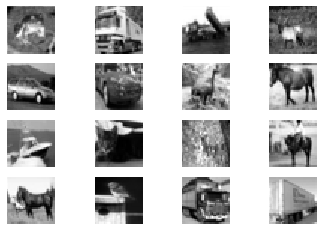

In [131]:
from keras.datasets.cifar10 import load_data
import tensorflow as tf

(X_train, y_train), (X_test, y_test) = load_data()

# Zet de training data om naar greyscale afbeeldingen en reshape naar 3d list
m, n = X_train.shape[::2]
X_train = tf.image.rgb_to_grayscale(X_train).numpy().transpose(0, 3, 1, 2).reshape(m, -1, n)
m, n = X_test.shape[::2]
X_test = tf.image.rgb_to_grayscale(X_test).numpy().transpose(0, 3, 1, 2).reshape(m, -1, n)

print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)

for i in range(16):
	plt.subplot(4, 4, 1 + i)
	plt.axis('off')
	plt.imshow(X_train[i], cmap = 'gray', interpolation = 'nearest')

In [134]:
# load fashion mnist images and transform the imagines into numbers between -1 and 1
def load_real_samples():
	# (trainX, _), (_, _) = load_data()

	X = expand_dims(X_train, axis = -1)
	X = X.astype('float32')
	X = (X - 127.5) / 127.5 # [0, 255] list, remove half and divide by halve to get values between -1 and 1
    
	return X

# Train methode
Aangepast om model met andere naam om te slaan

In [125]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)

	for i in range(n_epochs):
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, _ = d_model.train_on_batch(X_real, y_real)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d1 = %.3f, d2 = %.3f g = %.3f' % (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))

	# save the generator model
	g_model.save('generator_test.h5')

## Descriminator method

In [126]:
def define_discriminator(in_shape=(32, 32, 1)):
	model = Sequential()

	# downsamples
	model.add(Conv2D(128, (3, 3), strides = (2, 2), padding = 'same', input_shape = in_shape))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(128, (3, 3), strides = (2, 2), padding = 'same'))
	model.add(LeakyReLU(alpha=0.2))

	# classifier
	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation = 'sigmoid'))
	
	# compile model
	model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
	return model

## Generator method

In [127]:
def define_generator(latent_dim):
	model = Sequential()

	# foundation for 8x8 image
	n_nodes = 128 * 8 * 8
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha = 0.2))
	model.add(Reshape((8, 8, 128)))

	# upsample to 16x16
	model.add(Conv2DTranspose(128, (4, 4), strides = (2,2), padding='same'))
	model.add(LeakyReLU(alpha = 0.2))

	# upsample to 32x32
	model.add(Conv2DTranspose(128, (4, 4), strides = (2,2), padding='same'))
	model.add(LeakyReLU(alpha = 0.2))

	# generate
	model.add(Conv2D(1, (7, 7), activation = 'tanh', padding = 'same'))
	model.compile(loss = 'binary_crossentropy', optimizer = 'adam') # geen performance metric aangezien er afbeeldingen gemaakt worden
	return model

## Maak GAN model

In [128]:
def define_gan(generator, discriminator):
	discriminator.trainable = False

	model = Sequential()
	model.add(generator)
	model.add(discriminator)

	model.compile(loss = 'binary_crossentropy', optimizer = 'adam')
	return model

In [3]:
discriminator = define_discriminator()
generator = load_model('generator_test.h5')
gan_model = define_gan(generator, discriminator)
data = load_real_samples()
train(generator, discriminator, gan_model, data, latent_dim = 100, n_epochs = 1)

Output weggehaald aangezien het erg lang was


# Plot nieuwe afbeeldingen op ongetrained model

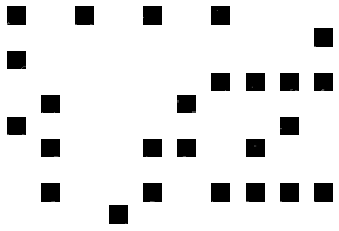

In [142]:
model = load_model('generator_test.h5')
latent_points = generate_latent_points(100, 100)
X = model.predict(latent_points)
show_plot(X, 10)

# Plot nieuwe afbeeldingen op 3 epochs getrained

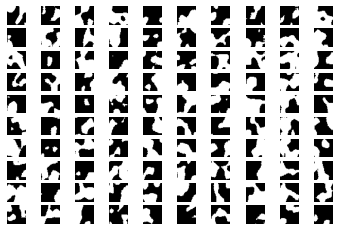

In [138]:
model = load_model('generator_test.h5')
latent_points = generate_latent_points(100, 100)
X = model.predict(latent_points)
show_plot(X, 10)